# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hemant\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'G:\database_assignment\Logistic_regression\database5.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
if not os.path.isfile('final.sqlite'):
    
    from tqdm import tqdm
    final_string=[]
    # tqdm is for printing the status bar
    for sentance in tqdm(final['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        final_string.append(sentance.strip())
        
         #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final05.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
   

In [23]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final1 = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [24]:
final1.head(3)
final1['CleanedText'].head(5)

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [25]:
sorted_sample = final1.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')    
sample_60000 = sorted_sample.iloc[0:100000]
final.shape
y = sample_60000['Score']


In [26]:
sample_60000.shape

(100000, 12)

In [27]:
sample_60000["length"] = sample_60000['Text'].apply(len)

In [28]:
sample_60000.shape

(100000, 13)

In [29]:
y.shape

(100000,)

In [30]:
sample_60000.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,length
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,375
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,407
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,166


In [31]:
sample_60000['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_ts, y_train, y_ts = train_test_split(sample_60000, y, test_size=0.33) # this is random splitting

In [33]:
x_train.shape

(67000, 13)

In [34]:
y_train.shape

(67000,)

In [35]:
x_ts.shape

(33000, 13)

In [36]:
y_ts.shape

(33000,)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.2] Bi-Grams and n-Grams.

In [37]:
#bi-gram, tri-gram and n-gram
from sklearn import preprocessing


#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1, 2),min_df=10) #in scikit-learn
x_tr_final_counts_bigram = count_vect.fit_transform(x_train['CleanedText'].values)
#x_cv_final_counts_bigram = count_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts_bigram = count_vect.transform(x_ts['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts_bigram))
print("the shape of out text BOW vectorizer ",x_tr_final_counts_bigram.get_shape())
print("the number of unique words ", x_tr_final_counts_bigram.get_shape()[1])

#print("the type of count vectorizer ",type(x_cv_final_counts_bigram))
#print("the shape of out text BOW vectorizer ",x_cv_final_counts_bigram.get_shape())
#print("the number of unique words ", x_cv_final_counts_bigram.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts_bigram))
print("the shape of out text BOW vectorizer ",x_ts_final_counts_bigram.get_shape())
print("the number of unique words ", x_ts_final_counts_bigram.get_shape()[1])


x_tr_final_counts_bigram = preprocessing.normalize(x_tr_final_counts_bigram)
#x_cv_final_counts_bigram = preprocessing.normalize(x_cv_final_counts_bigram)
x_ts_final_counts_bigram = preprocessing.normalize(x_ts_final_counts_bigram)





the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (67000, 38743)
the number of unique words  38743
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (33000, 38743)
the number of unique words  38743


## [4.3] TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2),min_df=10)
x_tr_final_counts_tfidf = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
#x_cv_final_counts_tfidf = tf_idf_vect.transform(x_cv['CleanedText'].values)
x_ts_final_counts_tfidf = tf_idf_vect.transform(x_ts['CleanedText'].values)


print("the type of count vectorizer ",type(x_tr_final_counts_tfidf))
print("the shape of out text TFIDF vectorizer ",x_tr_final_counts_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_tr_final_counts_tfidf.get_shape()[1])

#print("the type of count vectorizer ",type(x_cv_final_counts_tfidf))
#print("the shape of out text TFIDF vectorizer ",x_cv_final_counts_tfidf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", x_cv_final_counts_tfidf.get_shape()[1])

print("the type of count vectorizer ",type(x_ts_final_counts_tfidf))
print("the shape of out text TFIDF vectorizer ",x_ts_final_counts_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_ts_final_counts_tfidf.get_shape()[1])


x_tr_final_counts_tfidf = preprocessing.normalize(x_tr_final_counts_tfidf)
#x_cv_final_counts_tfidf = preprocessing.normalize(x_cv_final_counts_tfidf)
x_ts_final_counts_tfidf = preprocessing.normalize(x_ts_final_counts_tfidf)



the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (67000, 38743)
the number of unique words including both unigrams and bigrams  38743
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (33000, 38743)
the number of unique words including both unigrams and bigrams  38743


## [4.4] Word2Vec Train Data

In [39]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in x_train['CleanedText'].values:
    list_of_sentance_train.append(sentance.split())

In [ ]:
# Train your own Word2Vec model using your own text corpus
#i=0
#list_of_sentance_cv=[]
#for sentance in x_cv['CleanedText'].values:
#    list_of_sentance_cv.append(sentance.split())

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_ts=[]
for sentance in x_ts['CleanedText'].values:
    list_of_sentance_ts.append(sentance.split())

In [41]:
print(len(list_of_sentance_train))
#print(len(list_of_sentance_cv))
print(len(list_of_sentance_ts))

67000
33000


In [42]:
def convertByteStringtoString(sentlist):
    for x in sentlist:
        for i in range(len(x)):
            x[i] = x[i]
            
    return sentlist

In [43]:
list_of_sentance_train = convertByteStringtoString(list_of_sentance_train)
#list_of_sentance_cv = convertByteStringtoString(list_of_sentance_cv)
list_of_sentance_ts = convertByteStringtoString(list_of_sentance_ts)

In [44]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [45]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10576
sample words  ['high', 'recommend', 'gluten', 'free', 'diet', 'even', 'your', 'best', 'cooki', 'ive', 'ever', 'must', 'food', 'cabinet', 'expect', 'stronger', 'lemon', 'flavor', 'use', 'lot', 'realli', 'tast', 'terribl', 'pretti', 'mediocr', 'product', 'great', 'dog', 'keep', 'teeth', 'clean', 'breath', 'fresh', 'tri', 'alway', 'packag', 'hand', 'find', 'store', 'amazon', 'com', 'mix', 'make', 'good', 'oat', 'bran', 'muffin', 'easi', 'like', 'throw']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [46]:
# average Word2Vec
# compute average word2vec for each review.

train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avgw2v.append(sent_vec)
print(len(train_avgw2v))
print(len(train_avgw2v[0]))

100%|███████████████████████████████████| 67000/67000 [02:08<00:00, 522.05it/s]


67000
50


In [ ]:
"""
cv_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_avgw2v.append(sent_vec)
print(len(cv_avgw2v))
print(len(cv_avgw2v[0]))
"""

In [47]:
test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avgw2v.append(sent_vec)
print(len(test_avgw2v))
print(len(test_avgw2v[0]))

100%|███████████████████████████████████| 33000/33000 [01:05<00:00, 501.33it/s]


33000
50


In [48]:

train_avgw2v = preprocessing.normalize(train_avgw2v)
#cv_avgw2v = preprocessing.normalize(cv_avgw2v)
test_avgw2v = preprocessing.normalize(test_avgw2v)


In [49]:
train_avgw2v = np.array(train_avgw2v)
#cv_avgw2v = np.array(cv_avgw2v)
test_avgw2v = np.array(test_avgw2v)

In [50]:
np.isnan(train_avgw2v).any()


False

In [ ]:
#np.isnan(cv_avgw2v).any()


In [51]:
np.isnan(test_avgw2v).any()

False

#### [4.4.1.2] TFIDF weighted W2v

In [53]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
x_tr_final_counts_TFIDF_w2v = model.fit_transform(x_train['CleanedText'].values)
#x_cv_final_counts_TFIDF_w2v = model.transform(x_cv['CleanedText'].values)
x_ts_final_counts_TFIDF_w2v = model.transform(x_ts['CleanedText'].values)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [54]:
# TF-IDF weighted Word2Vec Train Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 67000/67000 [25:27<00:00, 57.95it/s]


In [ ]:
"""
# TF-IDF weighted Word2Vec cv Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
"""    

In [55]:
# TF-IDF weighted Word2Vec test Data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_ts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_ts.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 33000/33000 [13:29<00:00, 40.75it/s]


In [56]:

tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
#tfidf_sent_vectors_cv = preprocessing.normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_ts = preprocessing.normalize(tfidf_sent_vectors_ts)


In [57]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
#tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
tfidf_sent_vectors_ts = np.array(tfidf_sent_vectors_ts)

In [58]:
np.isnan(tfidf_sent_vectors).any()


False

In [ ]:
#np.isnan(tfidf_sent_vectors_cv).any()


In [59]:
np.isnan(tfidf_sent_vectors_ts).any()


False

In [100]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(x_tr_final_counts_bigram):
    print("%s %s" % (train, cv))
#    print(x_tr_final_counts_bigram[train].shape,x_tr_final_counts_bigram[cv].shape)

[   0    1    2 ... 6097 6098 6099] [ 6100  6101  6102 ... 12187 12188 12189]
[    0     1     2 ... 12187 12188 12189] [12190 12191 12192 ... 18277 18278 18279]
[    0     1     2 ... 18277 18278 18279] [18280 18281 18282 ... 24367 24368 24369]
[    0     1     2 ... 24367 24368 24369] [24370 24371 24372 ... 30457 30458 30459]
[    0     1     2 ... 30457 30458 30459] [30460 30461 30462 ... 36547 36548 36549]
[    0     1     2 ... 36547 36548 36549] [36550 36551 36552 ... 42637 42638 42639]
[    0     1     2 ... 42637 42638 42639] [42640 42641 42642 ... 48727 48728 48729]
[    0     1     2 ... 48727 48728 48729] [48730 48731 48732 ... 54817 54818 54819]
[    0     1     2 ... 54817 54818 54819] [54820 54821 54822 ... 60907 60908 60909]
[    0     1     2 ... 60907 60908 60909] [60910 60911 60912 ... 66997 66998 66999]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.7min finished


Best C is:- 10.0


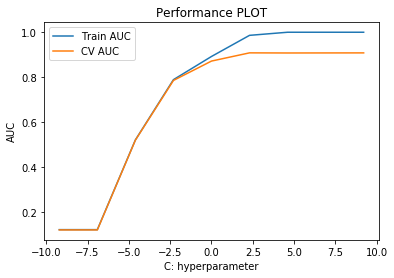

In [101]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000],
             'penalty':['l1'],'class_weight':['balanced']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv,verbose=1)
clf.fit(x_tr_final_counts_bigram,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [102]:
# LogisticRegression with best best "C" for l1 penalty of bow
model = LogisticRegression(penalty='l1',C = best_alpha,class_weight='balanced')
model.fit(x_tr_final_counts_bigram,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_bigram)    
    # evaluate CV AUC
auc_score_bowT_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(x_ts_final_counts_bigram)[:,1])*100
auc_score_bowT_lambda_l1 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_bowT_l1))    


The AUC of the Logistic Regression classifier of best C = 10.000000 is 93.795960%


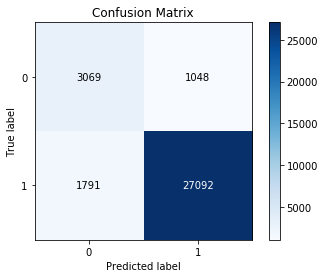

In [103]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


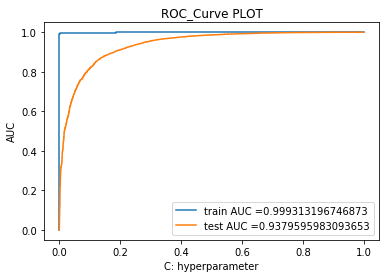

In [104]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_tr_final_counts_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(x_ts_final_counts_bigram)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




In [105]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.63      0.75      0.68      4117
          1       0.96      0.94      0.95     28883

avg / total       0.92      0.91      0.92     33000



Terminology

true positives (TP): We predicted +ve review, and review is also +ve. true negatives (TN): We predicted -ve, and review is also -ve. false positives (FP): We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.") false negatives (FN): We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")

False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1048/4117 = .25

In [190]:
# FPR for bowt_l1
bowt_FPR_l1 = .25

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [107]:
# Please write all the code with proper documentation
import numpy as np

clf = LogisticRegression(C=10, penalty='l1');
clf.fit(x_tr_final_counts_bigram,y_train);
w = clf.coef_
print(np.count_nonzero(w))


7788


In [108]:
clf = LogisticRegression(C=5, penalty='l1');
clf.fit(x_tr_final_counts_bigram,y_train);
w = clf.coef_
print(np.count_nonzero(w))


4955


In [109]:
clf = LogisticRegression(C=1, penalty='l1');
clf.fit(x_tr_final_counts_bigram,y_train);
w = clf.coef_
print(np.count_nonzero(w))


1041


In [110]:
clf = LogisticRegression(C=.1, penalty='l1');
clf.fit(x_tr_final_counts_bigram,y_train);
w = clf.coef_
print(np.count_nonzero(w))


156


In [111]:
clf = LogisticRegression(C=.01, penalty='l1');
clf.fit(x_tr_final_counts_bigram,y_train);
w = clf.coef_
print(np.count_nonzero(w))


7


we can see how drastically the sparsity increases from 7788 non zero weights(@ c = 10) to only 7 non zero weights(@ c = .01) 
when we use L1 regulariazation

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.7min finished


Best C is:- 100.0


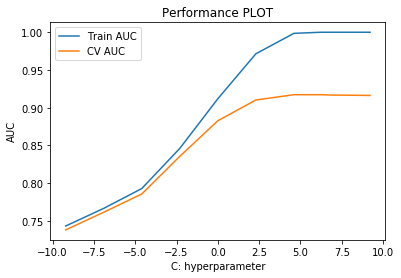

In [112]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000],
             'penalty':['l2'],'class_weight':['balanced']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv,verbose=1)
clf.fit(x_tr_final_counts_bigram,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [113]:
# LogisticRegression with best best "C" for l2 penalty of bow
model = LogisticRegression(penalty='l2',C = best_alpha,class_weight='balanced')
model.fit(x_tr_final_counts_bigram,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_bigram)    
    # evaluate CV AUC
auc_score_bowT_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(x_ts_final_counts_bigram)[:,1])*100
auc_score_bowT_lambda_l2 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_bowT_l2))    


The AUC of the Logistic Regression classifier of best C = 100.000000 is 94.313283%


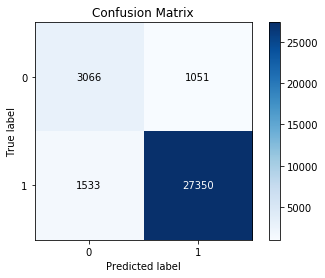

In [114]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)


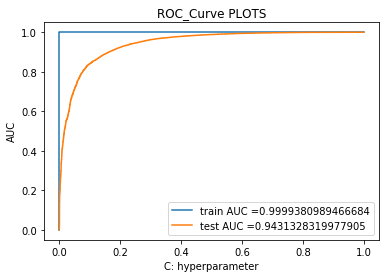

In [115]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_tr_final_counts_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(x_ts_final_counts_bigram)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOTS")
plt.show()




In [116]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.67      0.74      0.70      4117
          1       0.96      0.95      0.95     28883

avg / total       0.93      0.92      0.92     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1051/4117 = .25



In [191]:
# FPR for bowt_l2
bowt_FPR_l2 = .25

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [118]:
# Please write all the code with proper documentation
from scipy.sparse import find
#a.Get the (weights1)  after fit your model with the data X.
#weights before adding random noise
weights1 = find(model.coef_[0])[2]
print(weights1[:50])

[  1.18955656  -2.20009356   3.79440145  -0.07053348   0.45378631
   7.28808119  -0.57474561  -3.88172198   7.26022662  -4.26852288
   1.6210826    7.39560977  -0.48130551  -2.05348936  -2.50836553
  -0.60729209  -3.27374688   6.14993351  -3.0305784    6.59547615
   2.50748628  -1.2063141    0.76195719   1.30414638   8.28091731
  -1.861548    -2.34448654   0.19998559  -1.28097021   1.512335
  -0.03670947   0.57397928   0.13317334   0.37483528   2.94223169
   7.86971938   1.78820827   2.15211792   1.13798381   0.3512852
 -10.65293475   6.23239117   5.65749686  -3.40156139  -4.68244799
   3.47295991   0.36646869   1.25907923   1.66403164   3.12798741]


In [119]:
X_train_t = x_tr_final_counts_bigram
#Random noise
epsilon = np.random.uniform(low =-0.0001,high = 0.0001, size =(find(X_train_t)[0].size,))
# getting position (row and column) and values of non-zero datapoints 
a,b,c = find(X_train_t)
# b. Add a noise to the X (X' = X + e) and get the new data set X' 
#introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [120]:
model = LogisticRegression(penalty='l2',C = best_alpha)
model.fit(X_train_t,y_train)
pred = model.predict(x_ts_final_counts_bigram)
#c. We fit the model again on data X' and get the weights W'    
    # evaluate f1_score
f1_score_ = f1_score(y_ts, pred, average='macro') * float(100)
f1_score_alpha = best_alpha
print('\nThe f1_score of the Logistic Regression with L2 regularization of best_lambda = %f is %f%%' % (best_alpha, f1_score_))    


The f1_score of the Logistic Regression with L2 regularization of best_lambda = 100.000000 is 83.500513%


In [121]:
from scipy.sparse import find
#weights after adding random noise
weights2 = find(model.coef_[0])[2]
print(weights2[:50])

[ 0.93317797 -1.79010104  3.32703816  0.18401846  0.47362836  6.55801118
 -0.44313874 -3.19677187  6.45494622 -3.97413723  1.2499949   6.54233399
 -0.48307918 -1.52078951 -2.16624668 -0.61889575 -2.98064684  5.40695582
 -2.63858047  5.80743914  2.18778822 -0.95079399  0.72049404  1.01483783
  7.38966994 -1.63500559 -2.06358399  0.11771985 -1.15712472  1.25269522
 -0.10998717  0.44947128  0.14932183  0.34794874  2.69192087  6.79406958
  1.39999254  1.98385728  0.95861264  0.34039663 -9.05332461  5.56428249
  5.02898985 -3.07588068 -4.13261745  3.27181846  0.3402462   1.12594951
  1.41227537  2.7238462 ]


In [122]:
print(weights2.size)

38743


In [123]:
# Finding percentage change :
# d.Adding a very small value to avoid divison by zero error
weights1 = weights1 + 0.000001
weights2 = weights2 + 0.000001
#0.000001

In [124]:
# e. find the % change between W and W'
weights_dff = (abs(weights1 - weights2)/weights1)*100

In [125]:
print(weights_dff[np.where(weights_dff > 30)].size)

1863


14 features have weight changes greater than 30%. 

In [126]:
# Printing Percentiles :
for i in range(0, 101, 10):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(weights_dff, i)))

  0th Percentile value : -34578.20287
 10th Percentile value : -17.75843
 20th Percentile value : -13.65540
 30th Percentile value : -9.97454
 40th Percentile value : -0.91636
 50th Percentile value : 8.81428
 60th Percentile value : 11.92456
 70th Percentile value : 13.96748
 80th Percentile value : 16.19671
 90th Percentile value : 20.65157
100th Percentile value : 25857.83418


We see that there is a abrupt change when going from 90th percentile to 100th percentile.

In [127]:
# Printing close percentiles :
a = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in a:
    print("{:3}th Percentile value : {:.5f}".format(i, np.percentile(weights_dff, i)))

99.1th Percentile value : 119.65333
99.2th Percentile value : 132.77663
99.3th Percentile value : 148.04562
99.4th Percentile value : 178.91649
99.5th Percentile value : 213.51310
99.6th Percentile value : 268.63673
99.7th Percentile value : 332.20748
99.8th Percentile value : 471.43184
99.9th Percentile value : 806.08585
100th Percentile value : 25857.83418


We see that there is an abrupt change from 99.9th percentile to 100th percentile. Let' see what these values are 

In [128]:
# Creating dataframe of percentage change..
percendf = pd.DataFrame(weights_dff, index = count_vect.get_feature_names(), columns=['%Change'])
percendf

,%Change
abandon,21.552432
abc,-18.635240
abdomin,12.317178
abil,-360.900313
abl,4.372544
abl buy,10.017313
abl chew,-22.898322
abl continu,-17.645527
abl drink,11.091669
abl eat,-6.896665


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class and Negative class from<font color='red'> SET 1</font>

In [129]:
# Please write all the code with proper documentation
# To get all the features name 
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])

some sample features(unique words in the corpus) ['acidi', 'acknowledg', 'acn', 'acquaint', 'acquir', 'acquir tast', 'acr', 'acrid', 'across', 'across brand']


In [130]:
#code references :- https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
n = 10 
coefs_with_fns = sorted(zip(model.coef_[0],features))
top = zip(coefs_with_fns[:n],coefs_with_fns[:-(n+1):-1])

In [131]:
print("\t\tNegative\t\t\tPositive")
print("_"*80)
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

		Negative			Positive
________________________________________________________________________________
	-29.3667	two star       		19.2539	never disappoint
	-24.6908	worst          		18.4156	high recommend 
	-19.2238	way sweet      		16.3254	yum            
	-18.6567	candi delici   		16.1402	four star      
	-17.1764	terribl        		15.3324	skeptic        
	-17.1590	threw          		15.0703	delici         
	-16.4545	dont recommend 		15.0096	uniqu          
	-16.2274	great review   		14.4001	wont disappoint
	-16.1725	dissapoint     		14.2839	well worth     
	-16.1598	disappoint     		14.2629	fantast        


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [132]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv1 = TimeSeriesSplit(n_splits=10)
for train, cv in tscv1.split(x_tr_final_counts_tfidf):
    print("%s %s" % (train, cv))
#    print(x_tr_final_counts_bigram[train].shape,x_tr_final_counts_bigram[cv].shape)

[   0    1    2 ... 6097 6098 6099] [ 6100  6101  6102 ... 12187 12188 12189]
[    0     1     2 ... 12187 12188 12189] [12190 12191 12192 ... 18277 18278 18279]
[    0     1     2 ... 18277 18278 18279] [18280 18281 18282 ... 24367 24368 24369]
[    0     1     2 ... 24367 24368 24369] [24370 24371 24372 ... 30457 30458 30459]
[    0     1     2 ... 30457 30458 30459] [30460 30461 30462 ... 36547 36548 36549]
[    0     1     2 ... 36547 36548 36549] [36550 36551 36552 ... 42637 42638 42639]
[    0     1     2 ... 42637 42638 42639] [42640 42641 42642 ... 48727 48728 48729]
[    0     1     2 ... 48727 48728 48729] [48730 48731 48732 ... 54817 54818 54819]
[    0     1     2 ... 54817 54818 54819] [54820 54821 54822 ... 60907 60908 60909]
[    0     1     2 ... 60907 60908 60909] [60910 60911 60912 ... 66997 66998 66999]


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished


Best C is:- 10.0


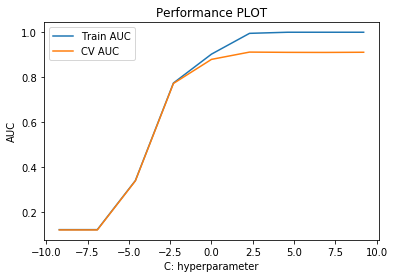

In [133]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000],
             'penalty':['l1'],'class_weight':['balanced']} 
tscv1 = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv1,verbose=1)
clf.fit(x_tr_final_counts_tfidf,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [134]:
# LogisticRegression with best best "C" for l1 penalty of bow
model = LogisticRegression(penalty='l1',C = best_alpha)
model.fit(x_tr_final_counts_tfidf,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_tfidf)    
    # evaluate CV AUC
auc_score_tfidf_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(x_ts_final_counts_tfidf)[:,1])*100
auc_score_tfidf_lambda_l1 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_tfidf_l1))    


The AUC of the Logistic Regression classifier of best C = 10.000000 is 93.826802%


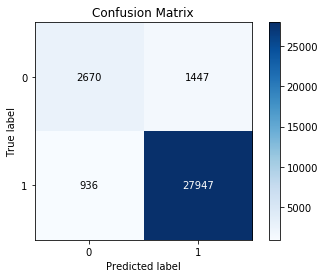

In [135]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts,pred)


In [136]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.74      0.65      0.69      4117
          1       0.95      0.97      0.96     28883

avg / total       0.92      0.93      0.93     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1447/4117 = .35

In [192]:
# FPR for tfidf_l1
tfidf_FPR_l1 = .35

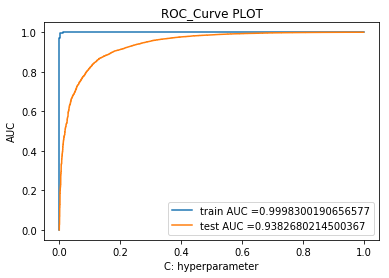

In [138]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_tr_final_counts_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(x_ts_final_counts_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()




### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished


Best C is:- 100.0


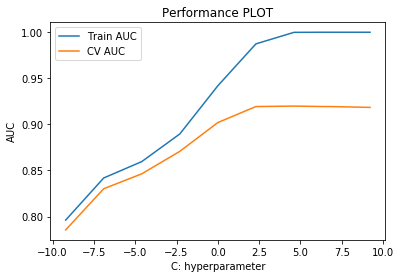

In [139]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100,500,1000,10000],
             'penalty':['l2'],'class_weight':['balanced']} 
tscv1 = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv1,verbose=1)
clf.fit(x_tr_final_counts_tfidf,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [140]:
# LogisticRegression with best best "C" for l2 penalty of bow
model = LogisticRegression(penalty='l2',C = best_alpha)
model.fit(x_tr_final_counts_tfidf,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(x_ts_final_counts_tfidf)    
    # evaluate CV AUC
auc_score_tfidf_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(x_ts_final_counts_tfidf)[:,1])*100
auc_score_tfidf_lambda_l2 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_tfidf_l2))    


The AUC of the Logistic Regression classifier of best C = 100.000000 is 94.203650%


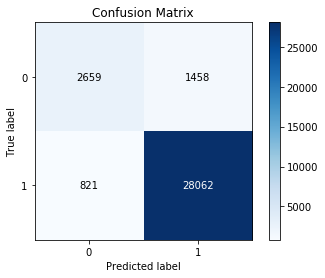

In [141]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

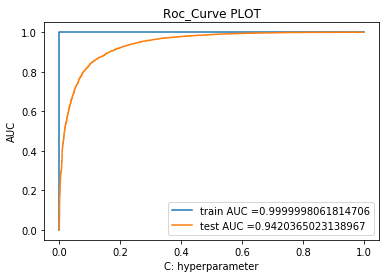

In [142]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_tr_final_counts_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(x_ts_final_counts_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Roc_Curve PLOT")
plt.show()



In [143]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.76      0.65      0.70      4117
          1       0.95      0.97      0.96     28883

avg / total       0.93      0.93      0.93     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1458/4117 = .35

In [193]:
# FPR for tfidf_l2
tfidf_FPR_l2 = .35

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class and Negative class from<font color='red'> SET 2</font>

In [145]:
# Please write all the code with proper documentation
# To get all the features name 
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:110])


some sample features(unique words in the corpus) ['acidi', 'acknowledg', 'acn', 'acquaint', 'acquir', 'acquir tast', 'acr', 'acrid', 'across', 'across brand']


In [146]:
n = 10 
coefs_with_fns = sorted(zip(model.coef_[0],features))
top = zip(coefs_with_fns[:n],coefs_with_fns[:-(n+1):-1])

In [147]:
print("\t\tNegative\t\t\tPositive")
print("_"*80)
for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

		Negative			Positive
________________________________________________________________________________
	-24.3494	two star       		26.3311	great          
	-23.5530	worst          		24.5588	delici         
	-22.7272	disappoint     		20.7322	best           
	-17.7830	terribl        		20.5878	perfect        
	-16.7495	candi delici   		20.3138	high recommend 
	-16.5353	horribl        		18.7786	love           
	-16.4240	threw          		17.0516	excel          
	-16.1894	aw             		17.0366	amaz           
	-15.7759	way sweet      		15.6025	never disappoint
	-14.8695	bland          		15.5662	fantast        


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [148]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv2 = TimeSeriesSplit(n_splits=10)
for train, cv in tscv1.split(train_avgw2v):
    print("%s %s" % (train, cv))
#    print(x_tr_final_counts_bigram[train].shape,x_tr_final_counts_bigram[cv].shape)

[   0    1    2 ... 6097 6098 6099] [ 6100  6101  6102 ... 12187 12188 12189]
[    0     1     2 ... 12187 12188 12189] [12190 12191 12192 ... 18277 18278 18279]
[    0     1     2 ... 18277 18278 18279] [18280 18281 18282 ... 24367 24368 24369]
[    0     1     2 ... 24367 24368 24369] [24370 24371 24372 ... 30457 30458 30459]
[    0     1     2 ... 30457 30458 30459] [30460 30461 30462 ... 36547 36548 36549]
[    0     1     2 ... 36547 36548 36549] [36550 36551 36552 ... 42637 42638 42639]
[    0     1     2 ... 42637 42638 42639] [42640 42641 42642 ... 48727 48728 48729]
[    0     1     2 ... 48727 48728 48729] [48730 48731 48732 ... 54817 54818 54819]
[    0     1     2 ... 54817 54818 54819] [54820 54821 54822 ... 60907 60908 60909]
[    0     1     2 ... 60907 60908 60909] [60910 60911 60912 ... 66997 66998 66999]


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


Best C is:- 1000.0


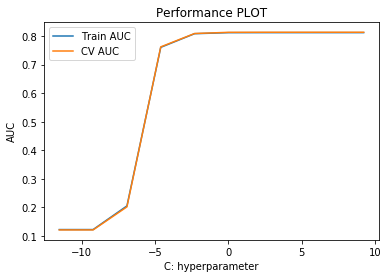

In [166]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
             'penalty':['l1'],'class_weight':['balanced']} 
tscv2 = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv2,verbose=1)
clf.fit(train_avgw2v,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [167]:
# LogisticRegression with best best "C" for l1 penalty of bow
model = LogisticRegression(penalty='l1',C = best_alpha)
model.fit(train_avgw2v,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(test_avgw2v)    
    # evaluate CV AUC
auc_score_word2vec_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(test_avgw2v)[:,1])*100
auc_score_word2vec_lambda_l1 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_word2vec_l1))    


The AUC of the Logistic Regression classifier of best C = 1000.000000 is 89.493334%


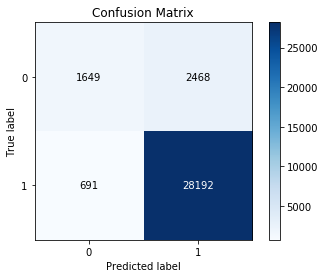

In [168]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

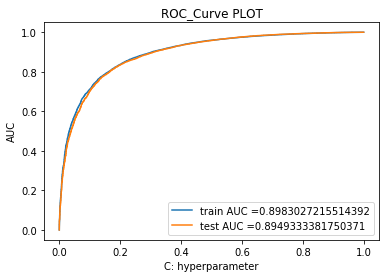

In [169]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC_Curve PLOT")
plt.show()



In [156]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.70      0.40      0.51      4117
          1       0.92      0.98      0.95     28883

avg / total       0.89      0.90      0.89     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2468/4117 = .59


In [194]:
# FPR for avgw2vec_l1
avgw2vec_FPR_l1 = .59

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   44.4s finished


Best C is:- 1000.0


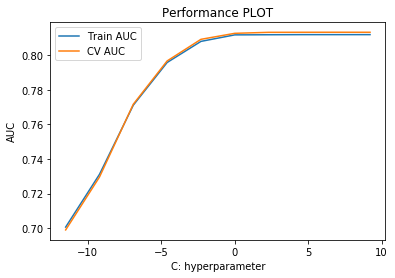

In [170]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
             'penalty':['l2'],'class_weight':['balanced']} 
tscv2 = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv2,verbose=1)
clf.fit(train_avgw2v,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [171]:
# LogisticRegression with best best "C" for l2 penalty of bow
model = LogisticRegression(penalty='l2',C = best_alpha)
model.fit(train_avgw2v,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(test_avgw2v)    
    # evaluate CV AUC
auc_score_word2vec_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(test_avgw2v)[:,1])*100
auc_score_word2vec_lambda_l2 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_word2vec_l2))    


The AUC of the Logistic Regression classifier of best C = 1000.000000 is 89.493154%


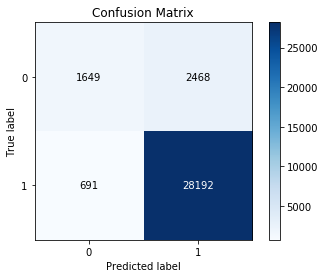

In [172]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

In [173]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.70      0.40      0.51      4117
          1       0.92      0.98      0.95     28883

avg / total       0.89      0.90      0.89     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2468/4117 = .59


In [195]:
# FPR for avgw2vec_l2
avgw2vec_FPR_l2 = .59

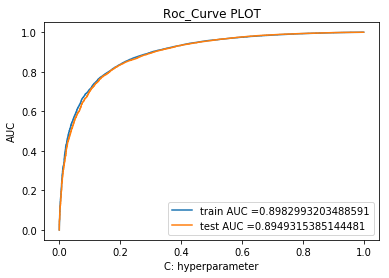

In [175]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Roc_Curve PLOT")
plt.show()



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [176]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv3 = TimeSeriesSplit(n_splits=10)
for train, cv in tscv1.split(train_avgw2v):
    print("%s %s" % (train, cv))
#    print(x_tr_final_counts_bigram[train].shape,x_tr_final_counts_bigram[cv].shape)

[   0    1    2 ... 6097 6098 6099] [ 6100  6101  6102 ... 12187 12188 12189]
[    0     1     2 ... 12187 12188 12189] [12190 12191 12192 ... 18277 18278 18279]
[    0     1     2 ... 18277 18278 18279] [18280 18281 18282 ... 24367 24368 24369]
[    0     1     2 ... 24367 24368 24369] [24370 24371 24372 ... 30457 30458 30459]
[    0     1     2 ... 30457 30458 30459] [30460 30461 30462 ... 36547 36548 36549]
[    0     1     2 ... 36547 36548 36549] [36550 36551 36552 ... 42637 42638 42639]
[    0     1     2 ... 42637 42638 42639] [42640 42641 42642 ... 48727 48728 48729]
[    0     1     2 ... 48727 48728 48729] [48730 48731 48732 ... 54817 54818 54819]
[    0     1     2 ... 54817 54818 54819] [54820 54821 54822 ... 60907 60908 60909]
[    0     1     2 ... 60907 60908 60909] [60910 60911 60912 ... 66997 66998 66999]


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


Best C is:- 100.0


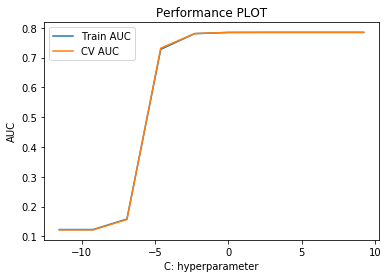

In [177]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
             'penalty':['l1'],'class_weight':['balanced']} 
tscv3 = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv3,verbose=1)
clf.fit(tfidf_sent_vectors,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [178]:
# LogisticRegression with best best "C" for l2 penalty of bow
model = LogisticRegression(penalty='l1',C = best_alpha)
model.fit(tfidf_sent_vectors,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(tfidf_sent_vectors_ts)    
    # evaluate CV AUC
auc_score_tfidf_word2vec_l1 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(tfidf_sent_vectors_ts)[:,1])*100
auc_score_tfidf_word2vec_lambda_l1 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_tfidf_word2vec_l1))    


The AUC of the Logistic Regression classifier of best C = 100.000000 is 86.772829%


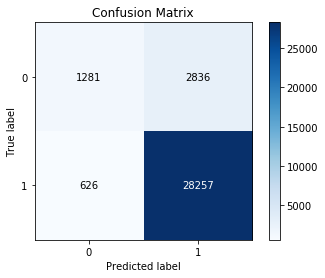

In [179]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

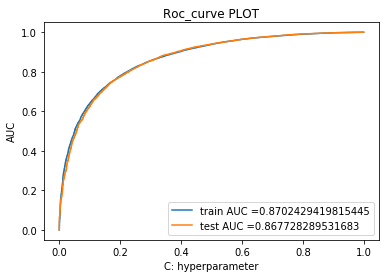

In [180]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(tfidf_sent_vectors_ts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Roc_curve PLOT")
plt.show()



In [181]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.67      0.31      0.43      4117
          1       0.91      0.98      0.94     28883

avg / total       0.88      0.90      0.88     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2836/4117 = .68


In [196]:
# FPR for tfidf_w2vec_l1
tfidf_w2vec_FPR_l1 = .68

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   47.8s finished


Best C is:- 1.0


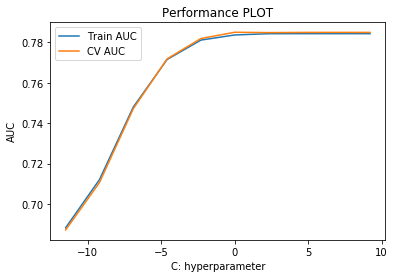

In [183]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from math import log
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

alpha_values = np.arange(10)
C = np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
cv_auc = []
train_auc = []


neigh = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000],
             'penalty':['l2'],'class_weight':['balanced']} 
tscv3 = TimeSeriesSplit(n_splits=10) #For time based splitting
clf = RandomizedSearchCV(neigh,param_grid,cv=tscv3,verbose=1)
clf.fit(tfidf_sent_vectors,y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



d = max(cv_auc)

i = np.where(cv_auc == d)

i = i[0][0]
best_alpha = float(C[i])
print("Best C is:-",best_alpha)     
    
    
C = np.log(C)    
    
plt.plot(C, train_auc, label='Train AUC')
plt.plot(C, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Performance PLOT")
plt.show()

In [184]:
# LogisticRegression with best best "C" for l2 penalty of bow
model = LogisticRegression(penalty='l2',C = best_alpha)
model.fit(tfidf_sent_vectors,y_train)
#pred = model.predict_proba(x_ts_final_counts_bigram)
pred=model.predict(tfidf_sent_vectors_ts)    
    # evaluate CV AUC
auc_score_tfidf_word2vec_l2 = roc_auc_score(y_true=np.array(y_ts), y_score=model.predict_proba(tfidf_sent_vectors_ts)[:,1])*100
auc_score_tfidf_word2vec_lambda_l2 = best_alpha
print('\nThe AUC of the Logistic Regression classifier of best C = %f is %f%%' % (best_alpha, auc_score_tfidf_word2vec_l2))    


The AUC of the Logistic Regression classifier of best C = 1.000000 is 86.776556%


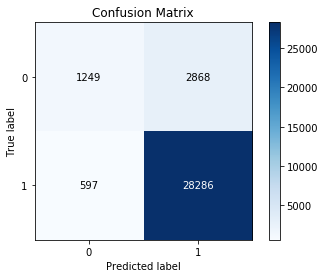

In [185]:
import scikitplot.metrics as skplt
skplt.plot_confusion_matrix(y_ts ,pred)

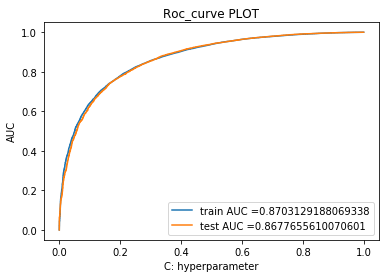

In [186]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_ts, model.predict_proba(tfidf_sent_vectors_ts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Roc_curve PLOT")
plt.show()



In [187]:
print(classification_report(y_ts, pred))

             precision    recall  f1-score   support

          0       0.68      0.30      0.42      4117
          1       0.91      0.98      0.94     28883

avg / total       0.88      0.90      0.88     33000



False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2868/4117 = .69


In [197]:
# FPR for tfidf_w2vec_l2
tfidf_w2vec_FPR_l2 = .69

# [6] Conclusions

In [198]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","penalty","hyperparameter(C)","roc_auc_score","FPR"]
x.add_row(["BOW","L1",auc_score_bowT_lambda_l1,auc_score_bowT_l1,bowt_FPR_l1])
x.add_row(["BOW","L2",auc_score_bowT_lambda_l2,auc_score_bowT_l2,bowt_FPR_l2])
x.add_row(["TF-IDF","L1",auc_score_tfidf_lambda_l1,auc_score_tfidf_l1,tfidf_FPR_l1])
x.add_row(["TF-IDF","L2",auc_score_tfidf_lambda_l2,auc_score_tfidf_l2,tfidf_FPR_l2])
x.add_row(["AVG -W2V","L1",auc_score_word2vec_lambda_l1,auc_score_word2vec_l1,avgw2vec_FPR_l1])
x.add_row(["AVG -W2V","L2",auc_score_word2vec_lambda_l2,auc_score_word2vec_l2,avgw2vec_FPR_l2])
x.add_row(["TFIDF-W2V","L1",auc_score_tfidf_word2vec_lambda_l1,auc_score_tfidf_word2vec_l1,tfidf_w2vec_FPR_l1])
x.add_row(["TFIDF-W2V","L2",auc_score_tfidf_word2vec_lambda_l2,auc_score_tfidf_word2vec_l2,tfidf_w2vec_FPR_l2])


print(x)

+------------+---------+-------------------+-------------------+------+
| Vectorizer | penalty | hyperparameter(C) |   roc_auc_score   | FPR  |
+------------+---------+-------------------+-------------------+------+
|    BOW     |    L1   |        10.0       | 93.79595983093652 | 0.25 |
|    BOW     |    L2   |       100.0       | 94.31328319977905 | 0.25 |
|   TF-IDF   |    L1   |        10.0       | 93.82680214500367 | 0.35 |
|   TF-IDF   |    L2   |       100.0       | 94.20365023138967 | 0.35 |
|  AVG -W2V  |    L1   |       1000.0      | 89.49333381750371 | 0.59 |
|  AVG -W2V  |    L2   |       1000.0      |  89.4931538514448 | 0.59 |
| TFIDF-W2V  |    L1   |       100.0       |  86.7728289531683 | 0.68 |
| TFIDF-W2V  |    L2   |        1.0        | 86.77655610070602 | 0.69 |
+------------+---------+-------------------+-------------------+------+


as per the table, we can consider BOW with L2 regularizor because it has less false positive rate  and more roc_auc_score